#**Aula 4 - Separando os dados em treino e teste**

Importando as bibliotecas necessárias:

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

Importando os dados:

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
doenca_cardiaca = fetch_ucirepo(id=45)

Criando a variável `X`, que contém as features e transformando a coluna `cp`em variáveis dummy:

In [ ]:
X = doenca_cardiaca.data.features
X = X[['age', 'chol', 'cp']]

df_cp = pd.get_dummies(X['cp'], prefix='cp')
X = X.drop('cp', axis=1).join(df_cp)

Criando a variável target:

In [ ]:
target = doenca_cardiaca.data.targets
target = (target > 0) * 1

Criando uma constante `entrada` e uma constante `y`:

In [ ]:
entrada = tf.constant(X, dtype=tf.float32)
y = tf.constant(target, dtype=tf.float32)

##**Separando e normalizando os dados**

Separando os dados em treino e teste:

In [ ]:
from sklearn.model_selection import train_test_split

X_treino, X_teste, y_treino, y_teste = train_test_split(entrada.numpy(), y.numpy(), test_size=0.2,
                                                        stratify=y.numpy(), random_state=4321)

Normalizando os dados com `StandardScaler()` e convertendo os dados de treino e teste para constantes do TensorFlow:

In [ ]:
# Normalizando os dados
scaler = StandardScaler()
X_treino = scaler.fit_transform(X_treino)
X_teste = scaler.transform(X_teste)

# Convertendo para tensores do TensorFlow
X_treino = tf.constant(X_treino, dtype=tf.float32)
X_teste = tf.constant(X_teste, dtype=tf.float32)
y_treino = tf.constant(y_treino, dtype=tf.float32)
y_teste = tf.constant(y_teste, dtype=tf.float32)

##**Aplicando o gradiente descendente**

Começamos definindo uma semente fixa para garantir a reprodutibilidade dos resultados, inicializamos os pesos e vieses da rede com valores aleatórios, e definimos a função do neurônio. Utiliza-se a descida de gradiente estocástica (SGD) como otimizador e a entropia cruzada binária para calcular a perda. O treinamento ocorre em um loop, atualizando os pesos e vieses para minimizar a perda, e armazena o valor da perda após cada época, imprimindo o progresso a cada 100 épocas:

In [ ]:
# Define uma semente para a geração de números aleatórios para garantir a reprodutibilidade dos resultado
tf.random.set_seed(31)

# Inicializa os pesos e vies da rede neural com valores aleatórios seguindo uma distribuição normal
quantidade_features = X_treino.shape[1]
pesos = tf.Variable(tf.random.normal([quantidade_features, 1]), name='pesos')
vies = tf.Variable(tf.random.normal([1]), name='vies')

# Define a função do neurônio
def neuronio(x):
  z = tf.add(tf.matmul(x, pesos), vies)
  return z

calculadora_perda = tf.keras.losses.BinaryCrossentropy() # Cria um objeto para calcular a perda
otimizador_treino = tf.optimizers.SGD(learning_rate=0.01) # Define o otimizador
QUANTIDADE_EPOCAS = 1000 # Define o número de épocas

# Inicializa uma lista para armazenar os valores da perda após cada época
perdas = []

# Loop de treinamento que itera sobre o número definido de épocas
for epoca in range(QUANTIDADE_EPOCAS):
  with tf.GradientTape() as tape:
    probabilidade = tf.sigmoid(neuronio(X_treino))
    custo = calculadora_perda(y_treino, probabilidade)

  # Calcula os gradientes da perda em relação aos pesos e ao viés.
  gradientes = tape.gradient(custo, [pesos, vies])
  # Aplica os gradientes aos pesos e ao viés para atualizá-los, tentando minimizar a perda.
  otimizador_treino.apply_gradients(zip(gradientes, [pesos, vies]))

  # Armazena o valor da perda após cada época
  perdas.append(custo.numpy())

  # A cada 100 épocas, imprime o número da época e o valor atual da perda.
  if (epoca + 1) % 100 == 0:
    print(f'Época: {epoca+1}, Custo: {custo.numpy()}')

Época: 100, Custo: 1.1161892414093018
Época: 200, Custo: 0.942953884601593
Época: 300, Custo: 0.8417884707450867
Época: 400, Custo: 0.7737382650375366
Época: 500, Custo: 0.7211429476737976
Época: 600, Custo: 0.6769532561302185
Época: 700, Custo: 0.6389795541763306
Época: 800, Custo: 0.6074031591415405
Época: 900, Custo: 0.5830978155136108
Época: 1000, Custo: 0.5661013126373291


Visualizando a perda por época:

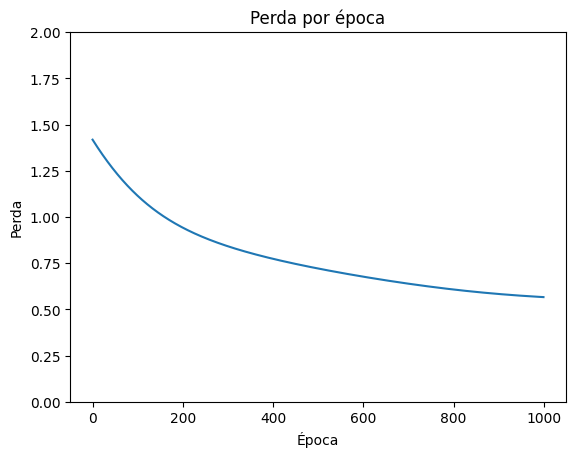

In [ ]:
import matplotlib.pyplot as plt

plt.plot(perdas)
plt.title('Perda por época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.ylim(0,2)
plt.show()

##**Testando diferentes taxas de aprendizagem**

Definindo a função `run_all()`, que inicializa pesos e vieses. A função configura um neurônio linear, aplica a função sigmóide para obter probabilidades, e utiliza o método do gradiente descendente (SGD) para minimizar a entropia cruzada binária como função de custo ao longo de 1000 épocas. Durante o treinamento, registra-se a perda em cada época e imprime a perda a cada 100 épocas, retornando o histórico das perdas ao final:


In [ ]:
def run_all():
  global pesos, vies
  tf.random.set_seed(31)

  quantidade_features = X_treino.shape[1]
  pesos = tf.Variable(tf.random.normal([quantidade_features, 1]), name='pesos')
  vies = tf.Variable(tf.random.normal([1]), name='vies')

  def neuronio(x):
    z = tf.add(tf.matmul(x, pesos), vies)
    return z

  calculadora_perda = tf.keras.losses.BinaryCrossentropy()
  otimizador_treino = tf.optimizers.SGD(learning_rate=learning_rate)
  QUANTIDADE_EPOCAS = 1000

  perdas = []

  for epoca in range(QUANTIDADE_EPOCAS):
    with tf.GradientTape() as tape:
      probabilidade = tf.sigmoid(neuronio(X_treino))
      custo = calculadora_perda(y_treino, probabilidade)

    gradientes = tape.gradient(custo, [pesos, vies])
    otimizador_treino.apply_gradients(zip(gradientes, [pesos, vies]))

    perdas.append(custo.numpy())

    if (epoca + 1) % 100 == 0:
      print(f'Época: {epoca+1}, Custo: {custo.numpy()}')

  return perdas

Explorando o impacto de diferentes valores de taxa de aprendizado (learning_rate) no treinamento de um modelo. A função `run_all()` é chamada quatro vezes com taxas de aprendizado de 0.0001, 0.01, 1.0 e 10, respectivamente, e as perdas resultantes de cada execução são armazenadas em variáveis separadas para análise posterior.

In [ ]:
learning_rate = 0.0001
perdas_00001 = run_all()

learning_rate = 0.01
perdas_001 = run_all()

learning_rate = 1.0
perdas_1 = run_all()

learning_rate = 10
perdas_10 = run_all()

Época: 100, Custo: 1.4142135381698608
Época: 200, Custo: 1.410361886024475
Época: 300, Custo: 1.4065293073654175
Época: 400, Custo: 1.4027159214019775
Época: 500, Custo: 1.3989207744598389
Época: 600, Custo: 1.3951462507247925
Época: 700, Custo: 1.3913874626159668
Época: 800, Custo: 1.3876466751098633
Época: 900, Custo: 1.3839229345321655
Época: 1000, Custo: 1.380216360092163
Época: 100, Custo: 1.1161892414093018
Época: 200, Custo: 0.942953884601593
Época: 300, Custo: 0.8417884707450867
Época: 400, Custo: 0.7737382650375366
Época: 500, Custo: 0.7211429476737976
Época: 600, Custo: 0.6769532561302185
Época: 700, Custo: 0.6389795541763306
Época: 800, Custo: 0.6074031591415405
Época: 900, Custo: 0.5830978155136108
Época: 1000, Custo: 0.5661013126373291
Época: 100, Custo: 0.5374215245246887
Época: 200, Custo: 0.537421464920044
Época: 300, Custo: 0.537421464920044
Época: 400, Custo: 0.537421464920044
Época: 500, Custo: 0.537421464920044
Época: 600, Custo: 0.537421464920044
Época: 700, Custo:

Visualizando as perdas por época:

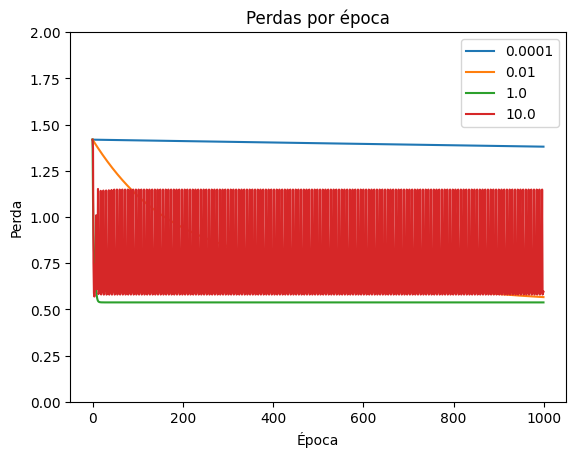

In [ ]:
plt.plot(perdas_00001)
plt.plot(perdas_001)
plt.plot(perdas_1)
plt.plot(perdas_10)
plt.title('Perdas por época')
plt.legend(['0.0001', '0.01', '1.0', '10.0'])
plt.xlabel('Época')
plt.ylabel('Perda')
plt.ylim(0,2)
plt.show()

#**Avaliando a taxa de acerto**

Treinando o modelo e obtendo as taxas de acerto nos dados de teste:

In [ ]:
# Inicializa listas vazias para armazenar o histórico de perdas e taxas de acerto ao longo do treinamento
perdas = []
taxas_acerto = []

# Define o otimizador a ser usado para ajustar os pesos do modelo
otimizador_treino = tf.optimizers.SGD(learning_rate=0.01)

# Inicializa os pesos e o viés
tf.random.set_seed(31)
quantidade_features = X_treino.shape[1]
pesos = tf.Variable(tf.random.normal([quantidade_features, 1]), name='pesos')
vies = tf.Variable(tf.random.normal([1]), name='vies')

# Loop de treinamento para a quantidade definida de épocas
for epoca in range(QUANTIDADE_EPOCAS):
  with tf.GradientTape() as tape:
    probabilidade = tf.sigmoid(neuronio(X_treino))
    custo = calculadora_perda(y_treino, probabilidade)

    gradientes = tape.gradient(custo, [pesos, vies])
    otimizador_treino.apply_gradients(zip(gradientes, [pesos, vies]))

    # Calcula a taxa de acerto nos dados de teste
    probabilidade_teste = tf.sigmoid(neuronio(X_teste))
    acertos = np.mean(y_teste.numpy() == ((probabilidade_teste.numpy() > 0.5) *1))
    taxas_acerto.append(acertos)

    # Adiciona o custo atual à lista de perdas para histórico
    perdas.append(custo.numpy())

  # A cada 100 épocas, imprime o número da época, o custo e a taxa de acerto
  if (epoca + 1) % 100 == 0:
    print(f'Época: {epoca+1}, Custo: {custo.numpy()}, Taxa de acerto: {acertos}')

Época: 100, Custo: 1.1161892414093018, Taxa de acerto: 0.45901639344262296
Época: 200, Custo: 0.942953884601593, Taxa de acerto: 0.6065573770491803
Época: 300, Custo: 0.8417884707450867, Taxa de acerto: 0.6721311475409836
Época: 400, Custo: 0.7737382650375366, Taxa de acerto: 0.7540983606557377
Época: 500, Custo: 0.7211429476737976, Taxa de acerto: 0.7540983606557377
Época: 600, Custo: 0.6769532561302185, Taxa de acerto: 0.7540983606557377
Época: 700, Custo: 0.6389795541763306, Taxa de acerto: 0.7540983606557377
Época: 800, Custo: 0.6074031591415405, Taxa de acerto: 0.7540983606557377
Época: 900, Custo: 0.5830978155136108, Taxa de acerto: 0.7540983606557377
Época: 1000, Custo: 0.5661013126373291, Taxa de acerto: 0.7540983606557377


In [ ]:
print(f'Menor custo obtido com um perceptron: {min(perdas)}')
print(f'Maior taxa de acerto obtida com um perceptron: {max(taxas_acerto)}')

Menor custo obtido com um perceptron: 0.5661013126373291
Maior taxa de acerto obtida com um perceptron: 0.7540983606557377


Visualizando as perdas e taxas de acerto por época:

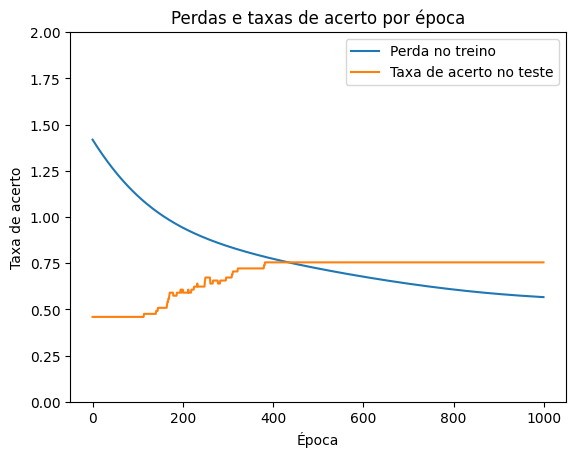

In [ ]:
plt.plot(perdas)
plt.plot(taxas_acerto)
plt.title('Perdas e taxas de acerto por época')
plt.legend(['Perda no treino', 'Taxa de acerto no teste'])
plt.xlabel('Época')
plt.ylabel('Taxa de acerto')
plt.ylim(0,2)
plt.show()